# Load data with pickle files

In [5]:
# Load the data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

In [6]:
import os 

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


# Load the observations

In [7]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

# Preprocessing of the data: $(x_{i,t,m}^{p})_{i=1,\ldots,I, t=1,\ldots,T,m=1,\ldots,M, p=1,\ldots,d}$
## $i$: ensemble member (run) index
## $t$: time index
## $m$: model index
## $p$: grid cell index

#### Keep the model with at least 3 ensemble memebers and downscale the data from latitude 144 -> 36 with local averaging (to match with ensemble methods

In [8]:
import skimage

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))

### 1) Compute anomalies: $\displaystyle \overline{x}_{i,t,m}^p = x_{i,t,m}^p - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \sum_{i=1}^I x_{i,t,m}^p$

In [9]:
# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
        else:
            mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
    
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = dic_processed_ssp585[m][i] - mean_ref_ensemble


/tmp/ipykernel_44546/4168053547.py:13: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
/tmp/ipykernel_44546/4168053547.py:15: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])


### 2) Compute the forced response: 
#### - Mean over space: $\displaystyle y_{i,t,m} = \frac{1}{P} \sum_{p=1}^P x_{i,t,m}^p$
#### - Mean over ensemble members: $\displaystyle \overline{y}_{t,m} = \frac{1}{I} \sum_{i=1}^I y_{i,t,m}$
#### - Set the mean to all the ensemble member forced responses: $y_{i,t,m} \colon= \overline{y}_{t,m}$
#### - Centering with respect to a given reference period: $\displaystyle y_{i,t,m} = y_{i,t,m} - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \overline{y}_{t,m}$

In [10]:
# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_spatial_ensemble = 0
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
        else:
            mean_spatial_ensemble += np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
            
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.mean(mean_spatial_ensemble[131:164])

## Now we can use the data to run some simple regression models

In [11]:
time_period = 33
grid_lat_size = 36
grid_lon_size = 72

y_forced_response = np.zeros((len(dic_forced_response_ssp585.keys()), time_period))
x_predictor = np.zeros((len(dic_forced_response_ssp585.keys()), time_period, grid_lat_size, grid_lat_size))

In [14]:
y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
       
        y_forced_response[m][i] = dic_forced_response_ssp585[m][i][131:164]
        x_predictor[m][i] = dic_processed_ssp585[m][i][131:164,:,:]

In [15]:
# compute the variance
vars_ssp585 = {}
std_ssp585 = {}
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    arr_tmp = np.zeros((len(dic_processed_ssp585[m].keys()),33))
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        arr_tmp[idx_i,:] = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=(1,2))
    vars_ssp585[m] = np.mean(np.var(arr_tmp,axis=0))
    std_ssp585[m] = np.mean(np.std(arr_tmp,axis=0))

# Define training set

In [18]:
import torch 

# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = {}
    y_train[m] = {}
    
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
    
        x_train[m][i] = torch.from_numpy(np.nan_to_num(x_predictor[m][i]).reshape(x_predictor[m][i].shape[0],x_predictor[m][i].shape[1]*x_predictor[m][i].shape[2])).to(torch.float64)
        y_train[m][i] = torch.from_numpy(np.nan_to_num(y_forced_response[m][i])).to(torch.float64)
    
        nans_idx = np.where(np.isnan(x_predictor[m][i][0,:,:].ravel()))[0]
        notnans_idx = np.where(np.isnan(x_predictor[m][i][0,:,:].ravel())==False)[0]

In [21]:
def train_single_ridge_regression(x,y,lon_size,lat_size,lambda_,nbEpochs=200,verbose=True):
    """
    Given a model m, learn parameter β^m such that β^m = argmin_{β}(||y_m - X_m^T β||^2) ).

    Args:
        - x, y: training set and training target 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - lambda_: regularizer coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    beta = torch.zeros(lon_size*lat_size).to(torch.float64)
    beta.requires_grad_(True)  
                          
    # define optimizer
    optimizer = torch.optim.Adam([beta],lr=1e-3)
            
    # --- optimization loop ---                
    for epoch in torch.arange(nbEpochs):      
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
                    
        # first term: ||Y - β^T X||
        obj = 0.5*torch.mean((y - torch.matmul(x,beta))**2)
        obj += 0.5*lambda_*torch.norm(beta,p=2)**2
                    
        #define loss function
        loss = obj
                    
        # Use autograd to compute the backward pass. 
        loss.backward(retain_graph=True)               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step()       
        
        if(verbose==True):
            if(epoch % 10 == 0):
                print('Epoch ', epoch.detach().item(), 
                    ', loss=', loss.detach().item()
                    )
    return beta.detach().clone()

In [30]:
def train_model_cross_validation(subset_runs,x,y,lon_size,lat_size,lambda_,nbEpochs=200,verbose=True):
    """
    Construct a training set and test set of a given 
        - x,y are the set of runs of a single model
    """
    # construct the training set
    y_train = 0
    y_test = 0
    x_train = 0
    x_test = 0
    
    for idx_r, r in enumerate(subset_runs):
        
        if idx_r ==0:
            y_train = y[r]
            x_train = x[r]
        else:
            y_train = torch.cat([y_train, y[r]])
            x_train = torch.cat([x_train, x[r]],axis=0)     

    print(x_train.shape)
    
    beta = train_single_ridge_regression(x_train,y_train,lon_size,lat_size,lambda_,nbEpochs,verbose)
    
    return beta

In [31]:
lambda_ = 1.0
model_name = 'CanESM5-1'
subset_runs = list(x_train[model_name].keys())


beta = train_model_cross_validation(subset_runs,x_train[model_name],y_train[model_name],grid_lon_size,grid_lat_size,lambda_,nbEpochs=200,verbose=True)

torch.Size([594, 2592])
Epoch  0 , loss= 0.01812482223991921
Epoch  10 , loss= 0.0056623124471836365
Epoch  20 , loss= 0.0021851613419648927
Epoch  30 , loss= 0.001056685594806546
Epoch  40 , loss= 0.0009882614819170087
Epoch  50 , loss= 0.0009925665814139565
Epoch  60 , loss= 0.0009280653819740859
Epoch  70 , loss= 0.0009218797295761194
Epoch  80 , loss= 0.000921480849497914
Epoch  90 , loss= 0.0009194430864425097
Epoch  100 , loss= 0.0009185108265310842
Epoch  110 , loss= 0.0009181699788204323
Epoch  120 , loss= 0.0009180389760789103
Epoch  130 , loss= 0.0009179902436185584
Epoch  140 , loss= 0.0009179832393598923
Epoch  150 , loss= 0.000917984751656057
Epoch  160 , loss= 0.0009179819967448434
Epoch  170 , loss= 0.0009179821384383284
Epoch  180 , loss= 0.0009179818121940622
Epoch  190 , loss= 0.0009179818386874275


In [14]:
def plot_betas(x,y,vars,lon_size,lat_size,lambda_):

    beta = torch.zeros(len(x.keys()),lon_size*lat_size)

    for idx_m,m in enumerate(x.keys()):
        # beta[idx_m,:] =  ridge_estimator(x[m],y[m],vars[m],lambda_)
        beta[idx_m,:] =  train_single_ridge_regression(x[m],y[m],vars[m],lon_size,lat_size,lambda_,nbEpochs=100,verbose=True)


    # plot the beta map of each mode
    fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    axs = axs.ravel()
    
    for idx_m, m in enumerate(x.keys()):
        
        beta_tmp = beta[idx_m,:].detach().clone()
        beta_tmp[nans_idx] = float('nan')
        beta_tmp = beta_tmp.detach().numpy().reshape(lat_size,lon_size)

        axs[idx_m].set_title(m+ ' ('+ str(len(dic_processed_ssp585[m].keys())) +') ')
        im0 = axs[idx_m].pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.01)

    plt.colorbar(im0, ax=axs[idx_m], shrink=0.5)

    for i in range(len(x.keys()),30):
        fig.delaxes(axs[i])

    fig.tight_layout()
    plt.show()

    return beta

Epoch  0 , loss= 5.471969879021917
Epoch  10 , loss= 1.622621218563701
Epoch  20 , loss= 0.5603815765450206
Epoch  30 , loss= 0.18423704959531437
Epoch  40 , loss= 0.13069700810216875
Epoch  50 , loss= 0.13017617460845976
Epoch  60 , loss= 0.09919055827803898
Epoch  70 , loss= 0.09175412471029702
Epoch  80 , loss= 0.08480133065275132
Epoch  90 , loss= 0.07863463698885124
Epoch  0 , loss= 0.6719141971806782
Epoch  10 , loss= 0.21483408546346924
Epoch  20 , loss= 0.06870855783804947
Epoch  30 , loss= 0.04389593685333127
Epoch  40 , loss= 0.023077132892818684
Epoch  50 , loss= 0.010345857076451023
Epoch  60 , loss= 0.007838711640539273
Epoch  70 , loss= 0.006121265807154967
Epoch  80 , loss= 0.005002240521803161
Epoch  90 , loss= 0.004550680415121879
Epoch  0 , loss= 6.262256182437079
Epoch  10 , loss= 1.4639284856985932
Epoch  20 , loss= 0.3730727538875038
Epoch  30 , loss= 0.08967214909718196
Epoch  40 , loss= 0.06818722327641184
Epoch  50 , loss= 0.034666697439331526
Epoch  60 , loss= 

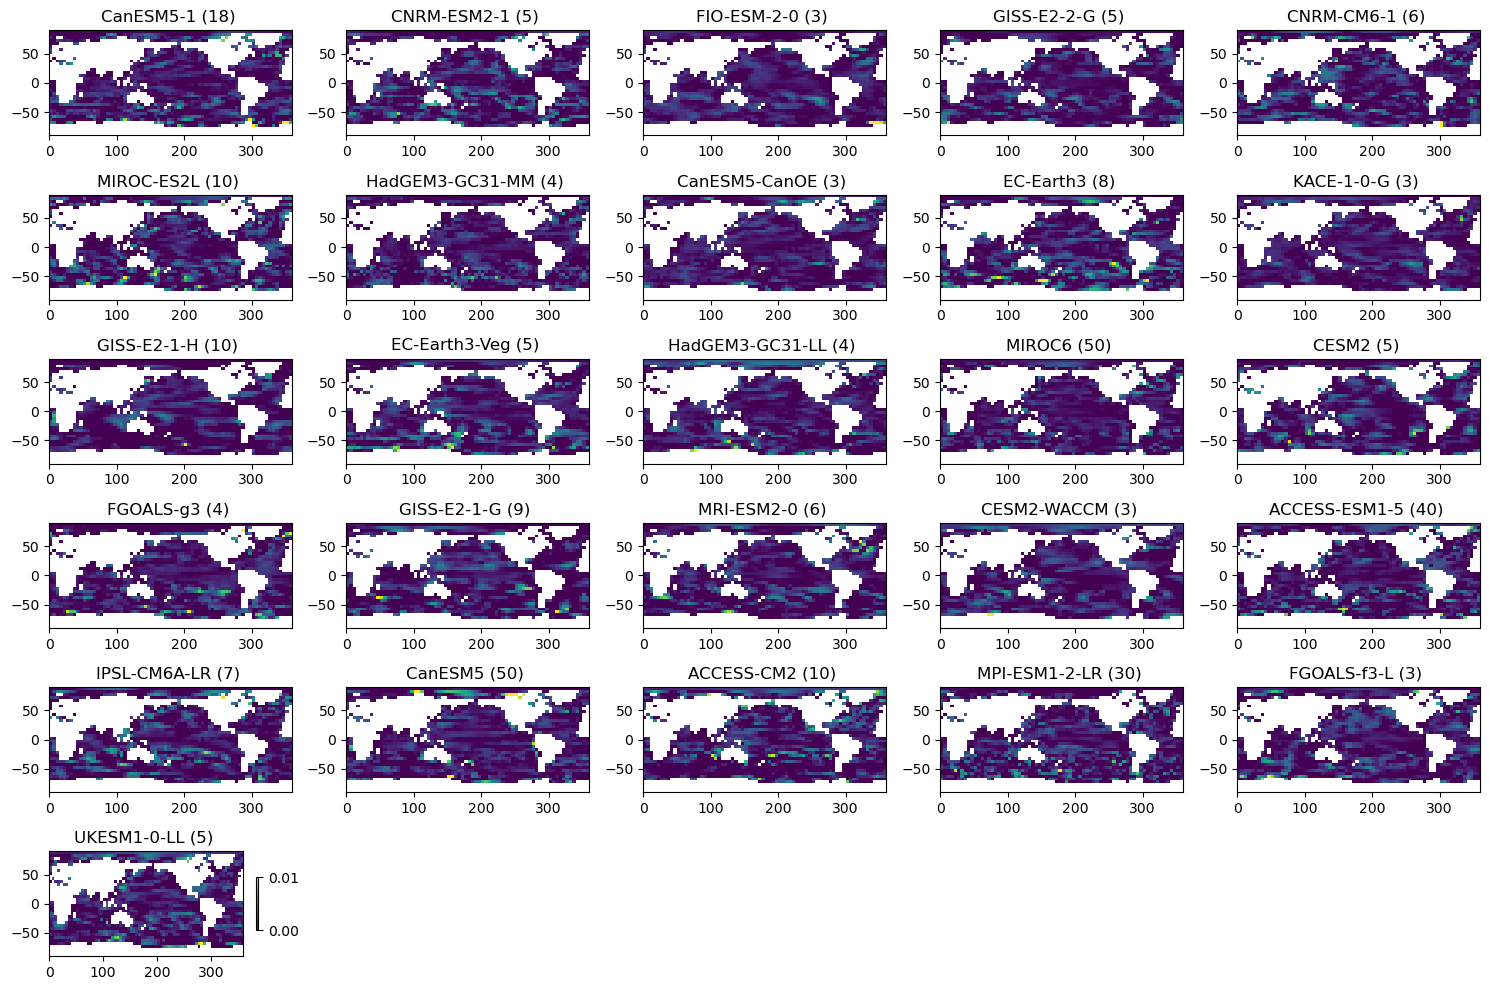

In [15]:
beta = plot_betas(x_train,y_train,vars_ssp585,grid_lon_size,grid_lat_size,1.0)

In [16]:
def plot_betas_descent(x,y,vars,lon_size,lat_size,lambda_,nbEpochs=500,verbose=True):

    beta = torch.zeros(len(x.keys()),lon_size*lat_size)

    for idx_m,m in enumerate(x.keys()):
        beta[idx_m,:] =  train_single_ridge_regression(x[m],y[m],vars[m],lon_size,lat_size,lambda_,nbEpochs,verbose)


    # plot the beta map of each mode
    fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 2.0, wspace=1.0)

    axs = axs.ravel()
    
    for idx_m, m in enumerate(x.keys()):
        
        beta_tmp = beta[idx_m,:].detach().clone()
        beta_tmp[nans_idx] = float('nan')
        beta_tmp = beta_tmp.detach().numpy().reshape(lat_size,lon_size)

        axs[idx_m].set_title(m)
        im0 = axs[idx_m].pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.01)

    plt.colorbar(im0, ax=axs[idx_m], shrink=0.5)

    for i in range(len(x.keys()),30):
        fig.delaxes(axs[i])

    fig.tight_layout()
    plt.show()

In [17]:
# plot_betas_descent(x_train,y_train,vars_ssp585,grid_lon_size,grid_lat_size,1.0,nbEpochs=5000,verbose=False)

# Analysis of the betas

### 1) PCA on the betas

In [18]:
# run with PCA with pytorch
U,S,V = torch.pca_lowrank(beta, q=6, center=False, niter=10)
proj_first_comp = torch.matmul(beta, V[:, :6])

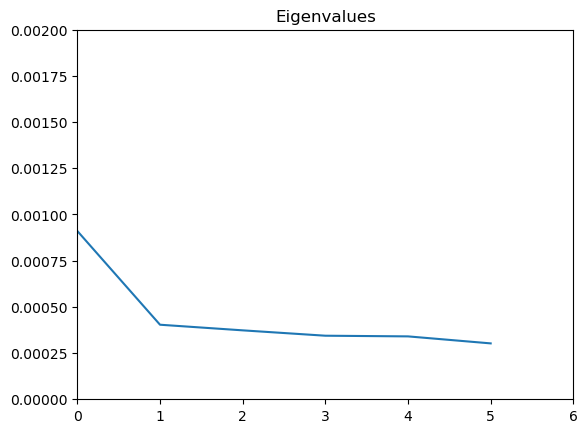

In [19]:
fig = plt.figure()
plt.plot(S**2/25)
plt.ylim((0.0,0.002))
plt.xlim((0.0,6))
plt.title('Eigenvalues')
plt.show()

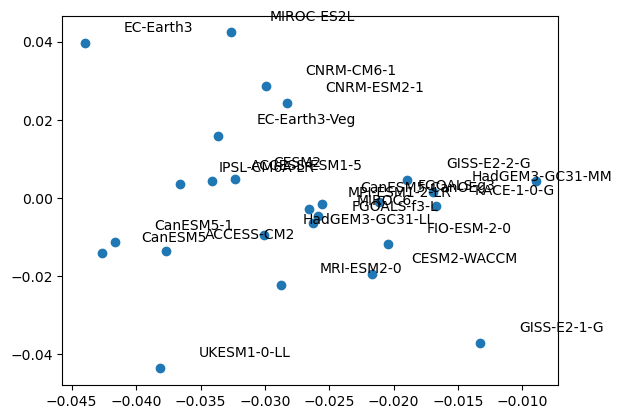

In [20]:
comp_x = 0
comp_y = 1

fig, ax = plt.subplots()
ax.scatter(proj_first_comp[:,comp_x],proj_first_comp[:,comp_y])

for idx_m, m in enumerate(dic_reduced_ssp585.keys()):
    ax.annotate(m, (proj_first_comp[idx_m,comp_x]+.003, proj_first_comp[idx_m,comp_y]+.003))

plt.show()

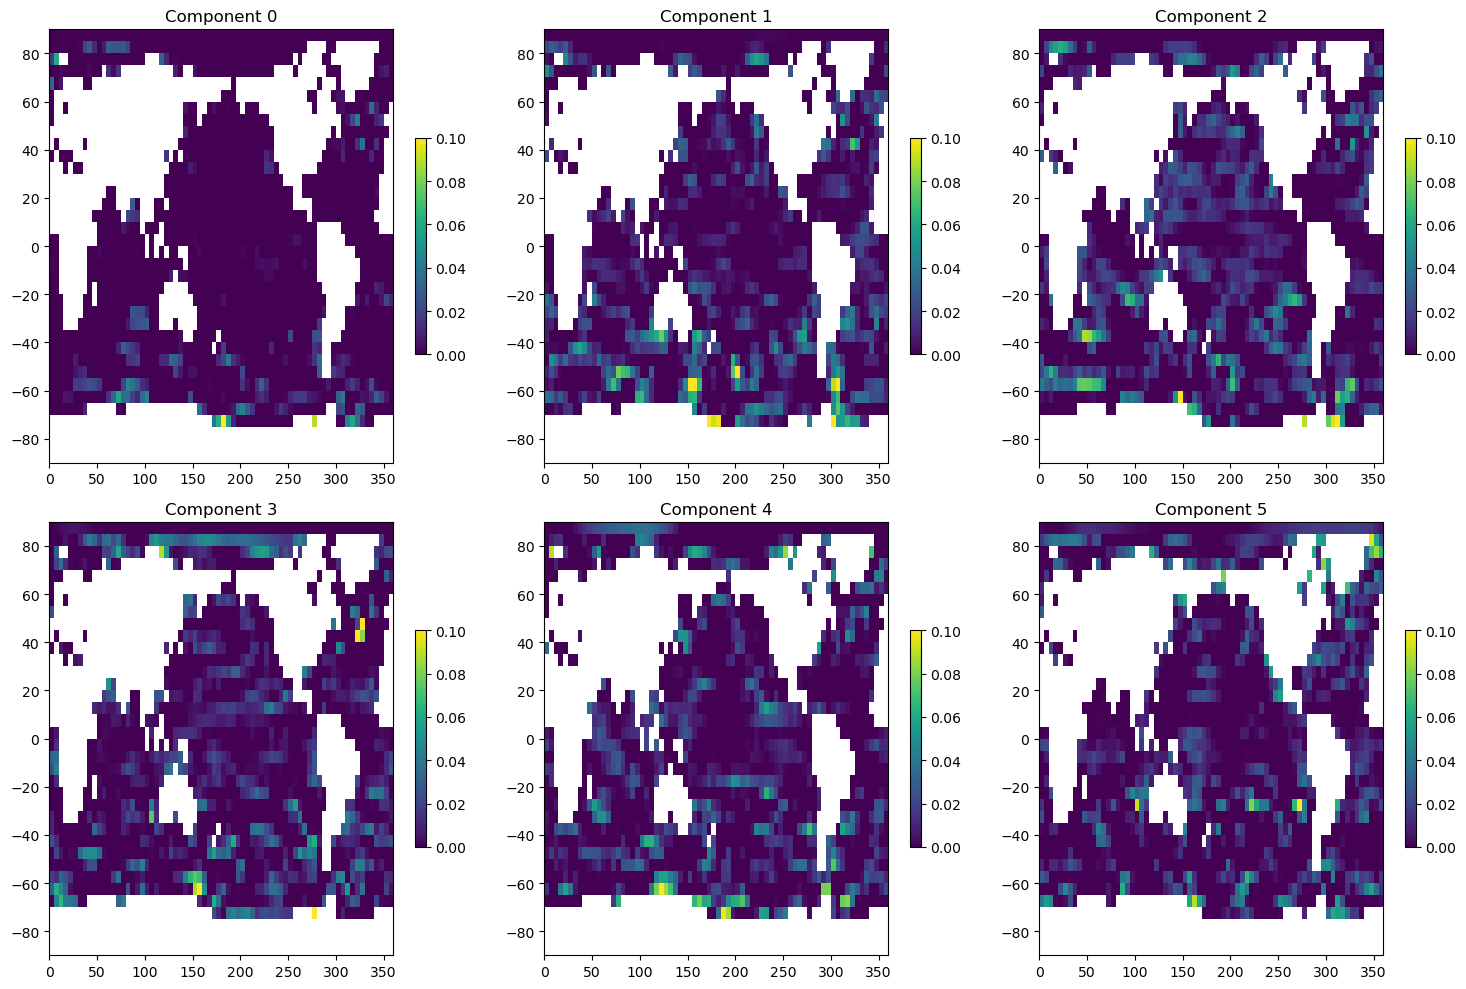

In [21]:
# plot the beta map of each mode
fig, axs = plt.subplots(2,3, figsize=(15,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2.0, wspace=1.0)

axs = axs.ravel()
    
for k in range(6):
        
    beta_tmp = V[:,k].detach().clone()
    beta_tmp[nans_idx] = float('nan')
    beta_tmp = beta_tmp.detach().numpy().reshape(grid_lat_size,grid_lon_size)

    axs[k].set_title('Component '+ str(k))
    im0 = axs[k].pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.1)

    plt.colorbar(im0, ax=axs[k], shrink=0.5)

fig.tight_layout()
plt.show()

### 2) Hierarchical clustering (within cluster variance based)

#### Ward based hierarchical clustering: minimize the total within cluster variance 

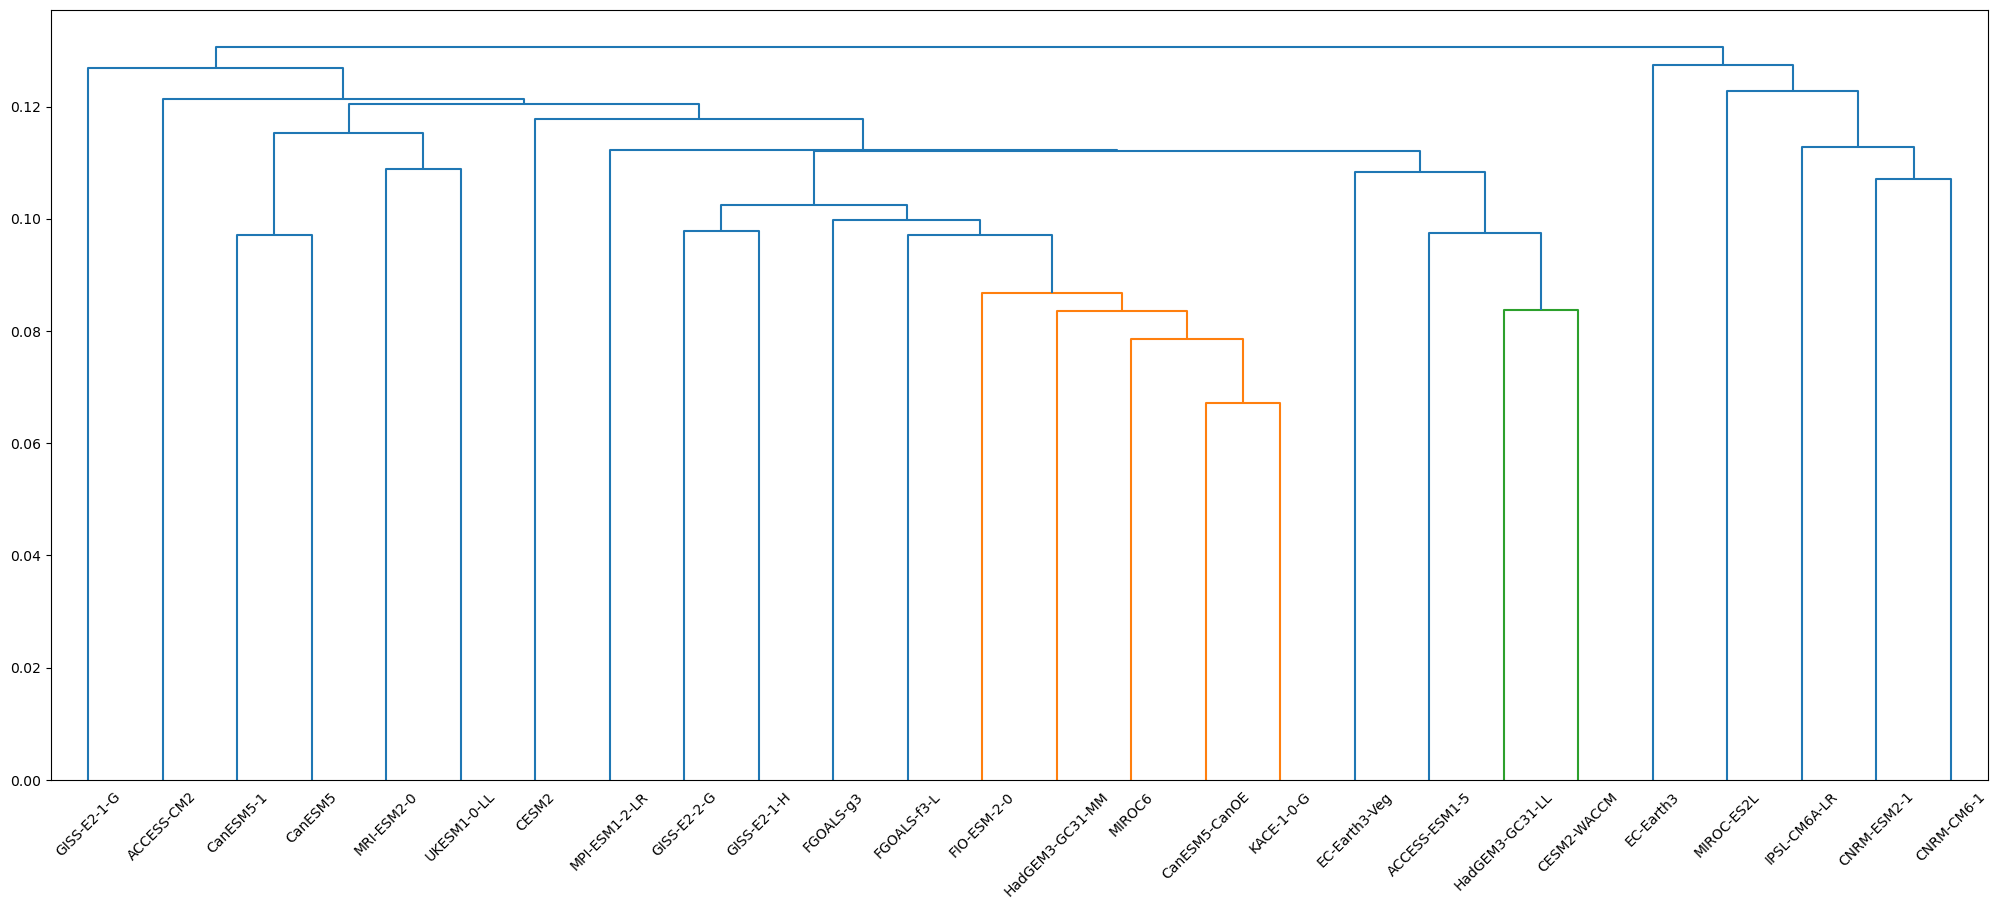

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

models = list(dic_reduced_ssp585.keys())
Z1 = linkage(beta.detach().numpy(), 'ward')
leaves_tmp = leaves_list(Z1)

labels_tmp =  [models[int(i)] for i in leaves_tmp] 


fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z1,labels = models)

#### plot the model variance to check how it impacts the clustering

/tmp/ipykernel_15619/138618491.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ordered_betas, rotation=-90)


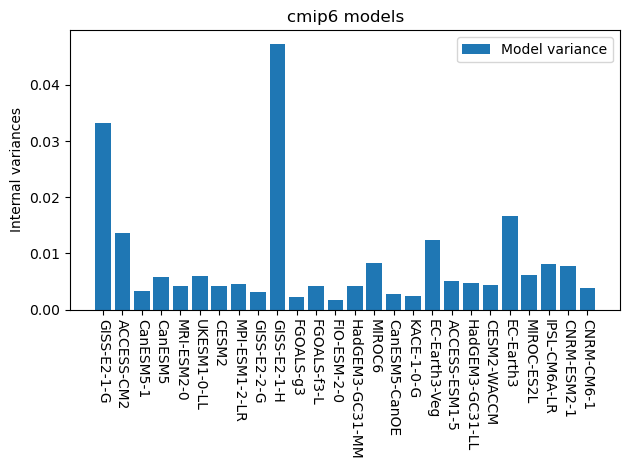

In [23]:
# compute the coefficient using soft max
M = len(list(dic_reduced_ssp585.keys()))
gamma = torch.zeros(M)
ordered_betas = [models[int(i)] for i in dn['leaves']]

for idx,i in enumerate(dn['leaves']):
    m = models[int(i)] 
    gamma[idx] = vars_ssp585[m]

# plot the model contributions
fig, ax = plt.subplots()
models = list(dic_reduced_ssp585.keys())
weights = list(gamma.detach().numpy())

ax.bar(models, weights,label='Model variance')
ax.set_ylabel(r'Internal variances')
ax.set_title('cmip6 models')
ax.legend()
ax.set_xticklabels(ordered_betas, rotation=-90)
plt.tight_layout()
plt.show()

### Plot the betas with respect to a given ordering

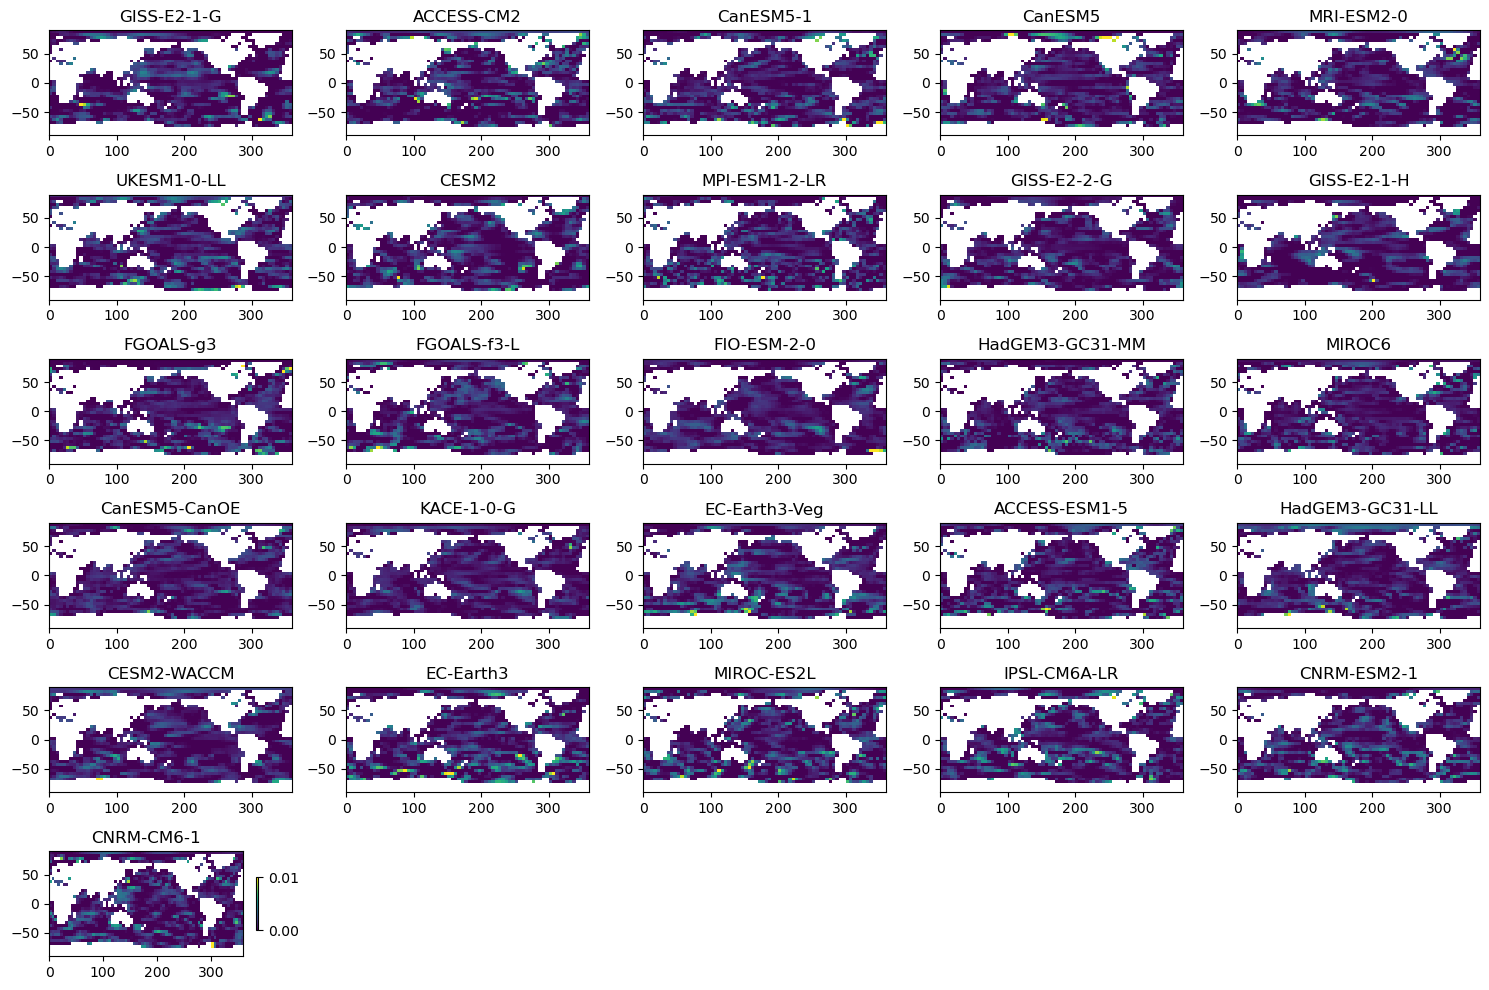

In [24]:
# plot the beta maps in the leaf-based ordering
fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2.0, wspace=1.0)

axs = axs.ravel()
    
for idx,i in enumerate(dn['leaves']):

    m = models[int(i)] 
    beta_tmp = beta[int(i),:].detach().clone()
    beta_tmp[nans_idx] = float('nan')
    beta_tmp = beta_tmp.detach().numpy().reshape(grid_lat_size,grid_lon_size)

    axs[idx].set_title(m)
    im0 = axs[idx].pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.01)

plt.colorbar(im0, ax=axs[idx], shrink=0.5)

for i in range(len(dic_reduced_ssp585.keys()),30):
    fig.delaxes(axs[i])

fig.tight_layout()
plt.show()